In [1]:
#Import Libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import ast
#Load Data
df = pd.read_csv('C:\\Users\\Joseans-M17\\Documents\\VScode VENV\\data_jobs.csv')
#Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

Goal: analyze which is the most optimal skill to learn when comparing the skill pay with the count of skills per job posting

In [22]:
# Filter for Data Analyst jobs in the US
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

# change job_skills list to seperate values
df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

# Changing column name to be more descriptive
df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

# Get the percent of skills per job count
DA_job_count = len(df_DA_US)
df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100

skill_percent = 5 # for cutting of values in the DF

df_DA_skills_HD = df_DA_skills[df_DA_skills['skill_percent'] > skill_percent]

df_DA_skills_HD

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


Start plotting

In [ ]:
# Creating a list of core technologies containing their associated program

df_tech = df['job_type_skills'].copy()

# remove duplicates
df_tech = df_tech.drop_duplicates()

# Remove NaN values
df_tech = df_tech.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_tech:
    row_dict = ast.literal_eval(row) # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict: # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:
            technology_dict[key] = value

#remove duplicates by converting values to set them back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))


In [41]:
# create a dataframe from above
df_tech = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_tech = df_tech.explode('skills')

# Merge it to high demand skills df
df_plot = df_DA_skills_HD.merge(df_tech, left_on='job_skills', right_on='skills')

In [42]:
df_plot = df_DA_skills_HD.merge(df_tech, left_on='job_skills', right_on='skills')

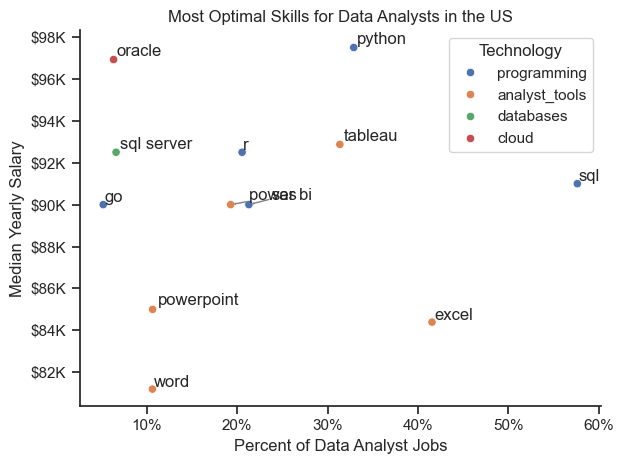

In [47]:
from adjustText import adjust_text

# df_plot.plot(kind='scatter', x='skill_percent', y='median_salary') # pandas plotting

sns.scatterplot(
    data=df_plot,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prep texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_HD.index):
    texts.append(plt.text(df_DA_skills_HD['skill_percent'].iloc[i], df_DA_skills_HD['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# format plot
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')
plt.legend(title='Technology')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,  pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

plt.tight_layout()
plt.show()